In [55]:
import pandas as pd
import numpy as np
import emoji
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [56]:
df = pd.read_csv("tweets_with_sentiment_1.csv")

In [57]:
def convert_emojis(text):
    return emoji.demojize(str(text), language='en')

In [58]:
df['text'] = df['text'].astype(str).apply(convert_emojis).apply(clean_text)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.dropna(subset=['text', 'sentiment'], inplace=True)


In [59]:
# Extract time features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['tweet_length'] = df['text'].apply(lambda x: len(x.split()))

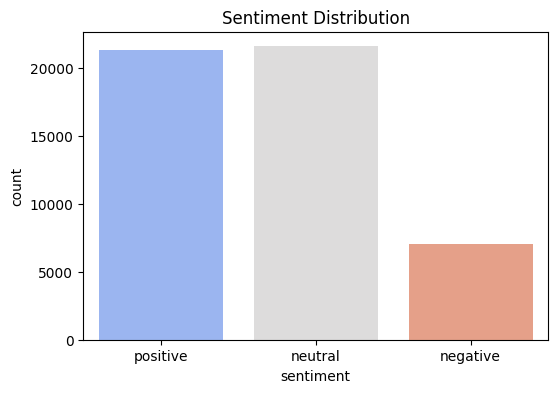

In [60]:
# Sentiment count
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='sentiment', hue='sentiment', palette='coolwarm', legend=False)
plt.title("Sentiment Distribution")
plt.show()

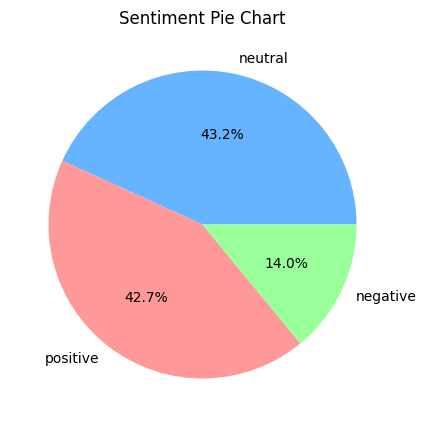

In [61]:
# Pie chart
plt.figure(figsize=(5, 5))
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#ff9999','#99ff99'])
plt.title("Sentiment Pie Chart")
plt.ylabel("")
plt.show()

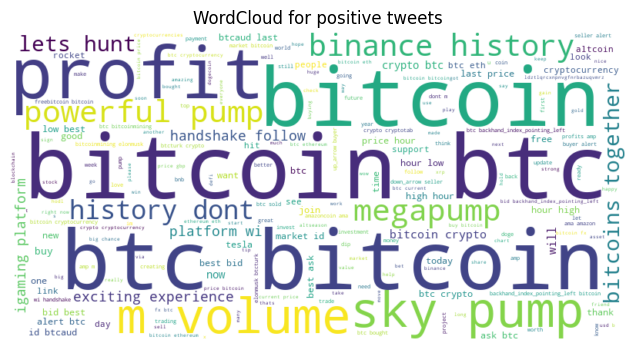

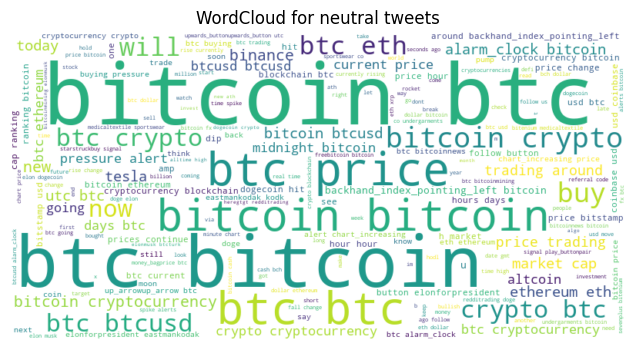

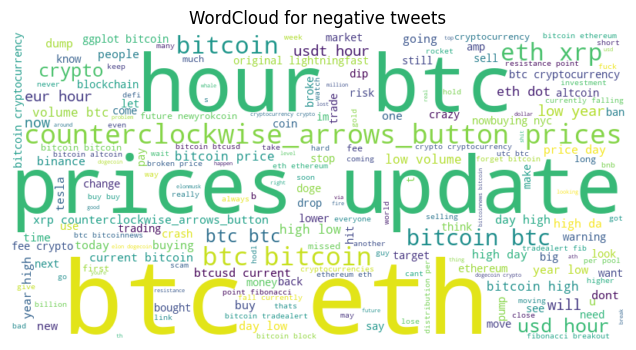

In [62]:
# WordClouds
for sentiment in df['sentiment'].unique():
    text = " ".join(df[df['sentiment'] == sentiment]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for {sentiment} tweets")
    plt.show()

In [63]:
# ========== ✂️ Vectorization ==========
X = df['text']
y = df['sentiment']

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [64]:
# ========== 🧪 Linear SVM ==========
print("🔍 Tuning Linear SVM...")
linear_params = {'C': [0.1, 1, 10]}
linear_grid = GridSearchCV(LinearSVC(), linear_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
linear_grid.fit(X_train, y_train)

y_pred_linear = linear_grid.predict(X_test)
print(f"\n✅ Best Linear SVM Params: {linear_grid.best_params_}")
print(f"Linear SVM Accuracy: {accuracy_score(y_test, y_pred_linear):.4f}")
print("\nClassification Report (Linear SVM):")
print(classification_report(y_test, y_pred_linear))

🔍 Tuning Linear SVM...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

✅ Best Linear SVM Params: {'C': 1}
Linear SVM Accuracy: 0.9082

Classification Report (Linear SVM):
              precision    recall  f1-score   support

    negative       0.86      0.73      0.79      1435
     neutral       0.89      0.96      0.92      4252
    positive       0.94      0.92      0.93      4313

    accuracy                           0.91     10000
   macro avg       0.90      0.87      0.88     10000
weighted avg       0.91      0.91      0.91     10000



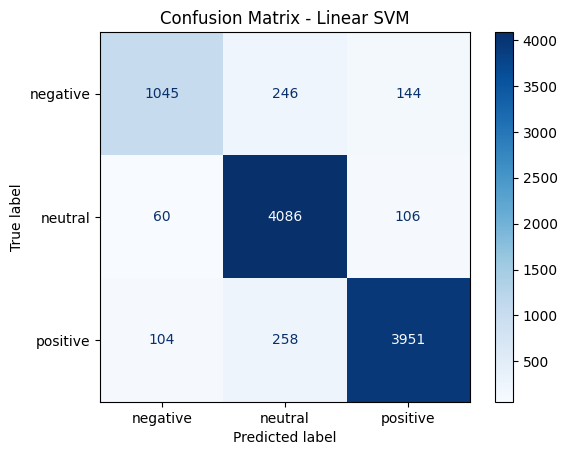

In [65]:
# Confusion Matrix - Linear SVM
cm_linear = confusion_matrix(y_test, y_pred_linear, labels=linear_grid.classes_)
disp_linear = ConfusionMatrixDisplay(confusion_matrix=cm_linear, display_labels=linear_grid.classes_)
disp_linear.plot(cmap='Blues')
plt.title("Confusion Matrix - Linear SVM")
plt.show()



In [66]:
# ========== 🔁 RBF SVM ==========
print("\n🔍 Tuning RBF SVM...")
rbf_params = {'C': [1, 10], 'gamma': ['scale', 0.01]}
rbf_grid = GridSearchCV(SVC(kernel='rbf'), rbf_params, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
rbf_grid.fit(X_train, y_train)


🔍 Tuning RBF SVM...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10], 'gamma': ['scale', 0.01]},
             scoring='accuracy', verbose=1)

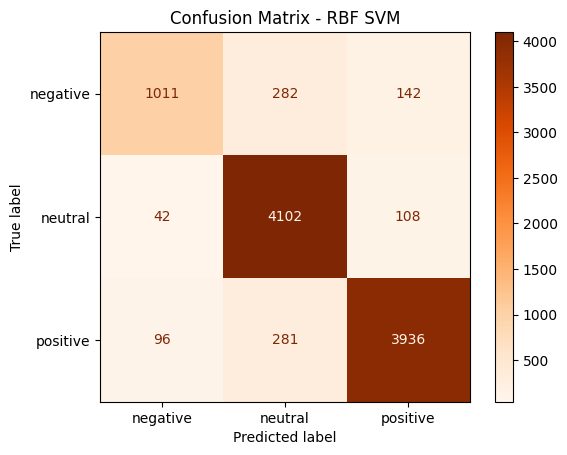

In [68]:
# After grid search fitting for RBF SVM is done
y_pred_rbf = rbf_grid.predict(X_test)

# Then create and plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_rbf = confusion_matrix(y_test, y_pred_rbf, labels=rbf_grid.classes_)
disp_rbf = ConfusionMatrixDisplay(confusion_matrix=cm_rbf, display_labels=rbf_grid.classes_)
disp_rbf.plot(cmap='Oranges')
plt.title("Confusion Matrix - RBF SVM")
plt.show()
